In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, img_dirs, transform=None):    def __init__(self, csv_file, img_dirs, transform=None):
        self.data = pd.read_csv(csv_file)        self.data = pd.read_csv(csv_file)
        self.img_dirs = img_dirs        self.img_dirs = img_dirs
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(self.data['dx'].unique())}        self.label_map = {label: idx for idx, label in enumerate(self.data['dx'].unique())}

    def __len__(self):    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['image_id'] + '.jpg'        img_name = self.data.iloc[idx]['image_id'] + '.jpg'
        img_path = None

        for dir in self.img_dirs:        for dir in self.img_dirs:
            if os.path.exists(os.path.join(dir, img_name)):            if os.path.exists(os.path.join(dir, img_name)):
                img_path = os.path.join(dir, img_name).join(dir, img_name)
                break                break

        if img_path is None:        if img_path is None:
            raise FileNotFoundError(f"Image {img_name} not found in any of the specified directories.")rectories.")

        image = Image.open(img_path).convert('RGB')        image = Image.open(img_path).convert('RGB')
        label = self.label_map[self.data.iloc[idx]['dx']]        label = self.label_map[self.data.iloc[idx]['dx']]

        if self.transform:        if self.transform:
            image = self.transform(image)            image = self.transform(image)

        return image, labellabel


In [ ]:
# Setting the Metadata Path
metadata_path = '../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

# Loading the Metadata
metadata = pd.read_csv(metadata_path)

# Checking the Number of Unique Images
print(f'Total number of images: {len(metadata)}')

Total number of images: 10015


In [ ]:
# Splitting the metadata into training and testing sets
train_metadata, test_metadata = train_test_split(metadata, test_size=0.99, random_state=42)

# Saving the split metadata to CSV files
train_metadata.to_csv('train_metadata.csv', index=False)
test_metadata.to_csv('test_metadata.csv', index=False)


In [ ]:
# Defining Image Directories
img_dirs = [img_dirs = [
    '../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1',    '../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1',
    '../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'    '../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
]

# Purpose of Image Directories# Purpose of Image Directories
# These directories are likely part of the dataset's structure, where the images have been split into multiple parts for organizational purposes.# These directories are likely part of the dataset's structure, where the images have been split into multiple parts for organizational purposes.
# By listing these directories, the code can later iterate through them to locate and load the images as needed.h them to locate and load the images as needed.
# This setup is crucial for managing and accessing the image files efficiently.# This setup is crucial for managing and accessing the image files efficiently.
# By specifying the directories in a list, the code can easily handle the images regardless of their distribution across multiple folders.# By specifying the directories in a list, the code can easily handle the images regardless of their distribution across multiple folders.
# This approach simplifies the process of loading and preprocessing the images for further analysis or model training.# This approach simplifies the process of loading and preprocessing the images for further analysis or model training.


In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),        # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

In [ ]:
# Creating Datasets
train_dataset = HAM10000Dataset(csv_file='train_metadata.csv', img_dirs=img_dirs, transform=transform)
test_dataset = HAM10000Dataset(csv_file='test_metadata.csv', img_dirs=img_dirs, transform=transform)

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# Printing Dataset Sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

Training dataset size: 100
Testing dataset size: 9915


Image batch shape: torch.Size([4, 3, 64, 64])
Label batch shape: torch.Size([4])


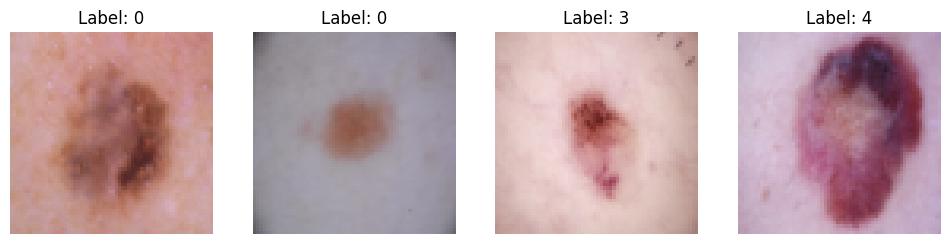

In [ ]:
import torch
import torch.nn as nnimport torch.nn as nn

# Self-Attention Class# Self-Attention Class
class SelfAttention(nn.Module):class SelfAttention(nn.Module):
    def __init__(self, in_dim):    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()ntion, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))er(torch.zeros(1))

    def forward(self, x):    def forward(self, x):
        batch_size, C, width, height = x.size()        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)batch_size, -1, width * height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x        out = self.gamma * out + x
        return out

# Residual Block Class# Residual Block Class
class ResidualBlock(nn.Module):class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels)            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):    def forward(self, x):
        return x + self.block(x)        return x + self.block(x)

# Generator Class# Generator Class
class Generator(nn.Module):class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, img_size=64, num_classes=7):    def __init__(self, latent_dim, img_channels, img_size=64, num_classes=7):
        super(Generator, self).__init__()self).__init__()
        self.label_emb = nn.Embedding(num_classes, latent_dim)        self.label_emb = nn.Embedding(num_classes, latent_dim)
        self.init_size = img_size // 4        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_channels, kernel_size=3, stride=1, padding=1),            nn.Conv2d(64, img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )        )

    def forward(self, noise, labels):    def forward(self, noise, labels):
        gen_input = noise * self.label_emb(labels))
        out = self.l1(gen_input)        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)        img = self.conv_blocks(out)
        return img

# Instantiating and Testing the Generator# Instantiating and Testing the Generator
latent_dim = 100latent_dim = 100
img_channels = 3
img_size = 64img_size = 64
num_classes = 7num_classes = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")ble() else "cpu")
generator = Generator(latent_dim, img_channels, img_size, num_classes).to(device)generator = Generator(latent_dim, img_channels, img_size, num_classes).to(device)

# Generate a batch of images# Generate a batch of images
noise = torch.randn(4, latent_dim).to(device).to(device)
labels = torch.randint(0, num_classes, (4,)).to(device)labels = torch.randint(0, num_classes, (4,)).to(device)
generated_images = generator(noise, labels)generated_images = generator(noise, labels)

# Print the shape of the generated imagesof the generated images
print(f'Generated images shape: {generated_images.shape}')print(f'Generated images shape: {generated_images.shape}')


Generated images shape: torch.Size([4, 3, 64, 64])


In [ ]:
import torch

# Self-Attention Classimport torch.nn as nn
class SelfAttention(nn.Module):
    def __init__(self, in_dim):# Self-Attention Class
        super(SelfAttention, self).__init__()class SelfAttention(nn.Module):
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)    def __init__(self, in_dim):
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)        super(SelfAttention, self).__init__()
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)v = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
    def forward(self, x):        self.gamma = nn.Parameter(torch.zeros(1))
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)    def forward(self, x):
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)        batch_size, C, width, height = x.size()
        energy = torch.bmm(proj_query, proj_key)        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        attention = torch.softmax(energy, dim=-1)v(x).view(batch_size, -1, width * height)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)        energy = torch.bmm(proj_query, proj_key)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))        attention = torch.softmax(energy, dim=-1)
        out = out.view(batch_size, C, width, height)        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        out = self.gamma * out + x.permute(0, 2, 1))
        return out        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
# Residual Block Class        return out
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):# Residual Block Class
        super(ResidualBlock, self).__init__()class ResidualBlock(nn.Module):
        self.block = nn.Sequential(    def __init__(self, in_channels):
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),        self.block = nn.Sequential(
            nn.ReLU(inplace=True),            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),            nn.BatchNorm2d(in_channels),
            nn.BatchNorm2d(in_channels)
        )            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels)
    def forward(self, x):        )
        return x + self.block(x)
    def forward(self, x):
# Discriminator Class        return x + self.block(x)
class Discriminator(nn.Module):
    def __init__(self, img_channels, img_size):# Discriminator Class
        super(Discriminator, self).__init__()class Discriminator(nn.Module):
        self.init_size = img_size // 4    def __init__(self, img_channels, img_size):
        self.l1 = nn.Sequential(nn.Linear(img_channels * img_size ** 2, 128 * self.init_size ** 2))        super(Discriminator, self).__init__()
        self.conv_blocks = nn.Sequential(img_size // 4
            nn.BatchNorm2d(128),        self.l1 = nn.Sequential(nn.Linear(img_channels * img_size ** 2, 128 * self.init_size ** 2))
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128, 0.8),            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),stride=2, padding=1),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),            nn.BatchNorm2d(128, 0.8),
            nn.BatchNorm2d(64, 0.8),            nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2, inplace=True),            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()            nn.LeakyReLU(0.2, inplace=True),
        )            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
        self.res_block = ResidualBlock(128)            nn.Sigmoid()
        self.attention = SelfAttention(128)
        self.res_block = ResidualBlock(128)
    def forward(self, img):        self.attention = SelfAttention(128)
        out = self.l1(img.view(img.size(0), -1))
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        out = self.res_block(out)        out = self.l1(img.view(img.size(0), -1))
        out = self.attention(out)        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        validity = self.conv_blocks(out)        out = self.res_block(out)
        return validity.view(validity.size(0), -1)
        validity = self.conv_blocks(out)
# Instantiating and Testing the Discriminator        return validity.view(validity.size(0), -1)
img_channels = 3
img_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")img_channels = 3
img_size = 64
discriminator = Discriminator(img_channels, img_size).to(device)device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate a batch of random fake imagesdiscriminator = Discriminator(img_channels, img_size).to(device)
fake_images = torch.randn(4, img_channels, img_size, img_size).to(device)
output = discriminator(fake_images)# Generate a batch of random fake images
 img_size).to(device)
# Print the shape of the discriminator's outputoutput = discriminator(fake_images)
print(f'Discriminator output shape: {output.shape}')


Discriminator output shape: torch.Size([4, 16])


In [ ]:
import warnings

# Ignore all warning messages
warnings.filterwarnings("ignore")

# Explanation:
# The warnings module is imported to handle warning messages in Python.
# The filterwarnings("ignore") function call sets a filter to ignore all warnings.
# This ensures that the output remains clean and free of warning messages.
# Use this with caution, as ignoring warnings might cause you to miss important information about potential issues in the code.


In [ ]:
from tqdm import tqdm
import torch.optim as optimimport torch.optim as optim
import torch.nn as nnimport torch.nn as nn
import torchimport torch

def train_gan(generator, discriminator, train_loader, latent_dim, device, epochs=1, lr=0.0002, beta1=0.5, beta2=0.999):def train_gan(generator, discriminator, train_loader, latent_dim, device, epochs=1, lr=0.0002, beta1=0.5, beta2=0.999):
    # Move models to the specified device    # Move models to the specified device
    generator.to(device)    generator.to(device)
    discriminator.to(device))

    # Loss function    # Loss function
    criterion = nn.BCEWithLogitsLoss()    criterion = nn.BCEWithLogitsLoss()

    # Optimizers    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

    # Mixed precision training    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler()    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        generator.train()        generator.train()
        discriminator.train()        discriminator.train()
        epoch_loss_G = 0.0        epoch_loss_G = 0.0
        epoch_loss_D = 0.0.0

        for real_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):        for real_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            batch_size = real_images.size(0)            batch_size = real_images.size(0)
            real_images = real_images.to(device)al_images.to(device)

            # Labels for real and fake images            # Labels for real and fake images
            valid = torch.ones(batch_size, 1).to(device)            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)            fake = torch.zeros(batch_size, 1).to(device)

            # -----------------            # -----------------
            #  Train Generator            #  Train Generator
            # -----------------------------
            optimizer_G.zero_grad()            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)            z = torch.randn(batch_size, latent_dim).to(device)

            with torch.cuda.amp.autocast():st():
                generated_images = generator(z)                generated_images = generator(z)
                g_loss = criterion(discriminator(generated_images), valid)                g_loss = criterion(discriminator(generated_images), valid)

            scaler.scale(g_loss).backward()            scaler.scale(g_loss).backward()
            scaler.step(optimizer_G)            scaler.step(optimizer_G)
            scaler.update()            scaler.update()

            epoch_loss_G += g_loss.item()h_loss_G += g_loss.item()

            # ---------------------            # ---------------------
            #  Train Discriminator            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()            optimizer_D.zero_grad()

            with torch.cuda.amp.autocast():            with torch.cuda.amp.autocast():
                real_loss = criterion(discriminator(real_images), valid)
                fake_loss = criterion(discriminator(generated_images.detach()), fake)                fake_loss = criterion(discriminator(generated_images.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2                d_loss = (real_loss + fake_loss) / 2

            scaler.scale(d_loss).backward()            scaler.scale(d_loss).backward()
            scaler.step(optimizer_D)            scaler.step(optimizer_D)
            scaler.update()            scaler.update()

            epoch_loss_D += d_loss.item()loss.item()

            # Clear CUDA cache            # Clear CUDA cache
            torch.cuda.empty_cache()            torch.cuda.empty_cache()

        print(f"Epoch [{epoch+1}/{epochs}] | Generator Loss: {epoch_loss_G/len(train_loader):.4f} | Discriminator Loss: {epoch_loss_D/len(train_loader):.4f}")        print(f"Epoch [{epoch+1}/{epochs}] | Generator Loss: {epoch_loss_G/len(train_loader):.4f} | Discriminator Loss: {epoch_loss_D/len(train_loader):.4f}")

# Example function call# Example function call
# train_gan(generator, discriminator, train_loader, latent_dim, device, epochs=10)# train_gan(generator, discriminator, train_loader, latent_dim, device, epochs=10)


In [ ]:
import torch
from torchvision import modelsfrom torchvision import models
import warningsimport warnings
import torch.nn as nnimport torch.nn as nn
import torch.optim as optim

# Ignore all warning messages# Ignore all warning messages
warnings.filterwarnings("ignore")warnings.filterwarnings("ignore")

# EfficientNetV2 Classifier# EfficientNetV2 Classifier
class EfficientNetV2Classifier(nn.Module):class EfficientNetV2Classifier(nn.Module):
    def __init__(self, num_classes=7):    def __init__(self, num_classes=7):
        super(EfficientNetV2Classifier, self).__init__()        super(EfficientNetV2Classifier, self).__init__()
        self.model = models.efficientnet_v2_s(pretrained=True)        self.model = models.efficientnet_v2_s(pretrained=True)
        self.model.classifier = nn.Sequential(        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(self.model.classifier[1].in_features, num_classes)(self.model.classifier[1].in_features, num_classes)
        )        )

    def forward(self, x):    def forward(self, x):
        return self.model(x))

# Model Initialization# Model Initialization
model_EfficientNetV2 = EfficientNetV2Classifier(num_classes=7)model_EfficientNetV2 = EfficientNetV2Classifier(num_classes=7)

# Loss and Optimizer# Loss and Optimizer
criterion = nn.CrossEntropyLoss()criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_EfficientNetV2.parameters(), lr=0.001)optimizer = optim.Adam(model_EfficientNetV2.parameters(), lr=0.001)

# Training Loop# Training Loop
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cuda'):def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)    model.to(device)
    for epoch in range(num_epochs):):
        model.train()        model.train()
        running_loss = 0.0        running_loss = 0.0
        total_correct = 0        total_correct = 0
        for inputs, labels in train_loader:        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()            optimizer.zero_grad()
            outputs = model(inputs)            outputs = model(inputs)
            loss = criterion(outputs, labels)n(outputs, labels)
            loss.backward()            loss.backward()
            optimizer.step()            optimizer.step()
            running_loss += loss.item() * inputs.size(0)            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)1)
            total_correct += torch.sum(preds == labels.data)            total_correct += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_loader.dataset)        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = total_correct.double() / len(train_loader.dataset)        epoch_acc = total_correct.double() / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')pochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')
        validate_model(model, test_loader, criterion, device)        validate_model(model, test_loader, criterion, device)

# Validation Loop# Validation Loop
def validate_model(model, test_loader, criterion, device='cuda'):='cuda'):
    model.eval()    model.eval()
    total_correct = 0    total_correct = 0
    total_loss = 0.0    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)            total_correct += torch.sum(preds == labels.data)
    avg_loss = total_loss / len(test_loader.dataset)dataset)
    avg_acc = total_correct.double() / len(test_loader.dataset)    avg_acc = total_correct.double() / len(test_loader.dataset)
    print(f'Validation Loss: {avg_loss:.4f} | Validation Accuracy: {avg_acc:.4f}')    print(f'Validation Loss: {avg_loss:.4f} | Validation Accuracy: {avg_acc:.4f}')

# Example function call
# train_model(model_EfficientNetV2, train_loader, test_loader, criterion, optimizer, num_epochs=10)# train_model(model_EfficientNetV2, train_loader, test_loader, criterion, optimizer, num_epochs=10)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:03<00:00, 23.1MB/s]


In [ ]:
import torch
from torchvision import modelsfrom torchvision import models
import torch.nn as nnimport torch.nn as nn
import torch.optim as optimimport torch.optim as optim

# ShuffleNetV2 Classifier# ShuffleNetV2 Classifier
class ShuffleNetV2Classifier(nn.Module):class ShuffleNetV2Classifier(nn.Module):
    def __init__(self, num_classes=7):    def __init__(self, num_classes=7):
        super(ShuffleNetV2Classifier, self).__init__()        super(ShuffleNetV2Classifier, self).__init__()
        self.model = models.shufflenet_v2_x1_0(pretrained=True)        self.model = models.shufflenet_v2_x1_0(pretrained=True)
        self.model.fc = nn.Sequential(        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(self.model.fc.in_features, num_classes)(self.model.fc.in_features, num_classes)
        )        )

    def forward(self, x):    def forward(self, x):
        return self.model(x))

# Model Initialization# Model Initialization
model_ShuffleNetV2 = ShuffleNetV2Classifier(num_classes=7)model_ShuffleNetV2 = ShuffleNetV2Classifier(num_classes=7)

# Loss and Optimizer# Loss and Optimizer
criterion = nn.CrossEntropyLoss()criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ShuffleNetV2.parameters(), lr=0.001)optimizer = optim.Adam(model_ShuffleNetV2.parameters(), lr=0.001)

# Training Loop# Training Loop
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cuda'):def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)    model.to(device)
    for epoch in range(num_epochs):
        model.train()        model.train()
        running_loss = 0.0        running_loss = 0.0
        total_correct = 0        total_correct = 0
        for inputs, labels in train_loader:ader:
            inputs, labels = inputs.to(device), labels.to(device)            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()            optimizer.zero_grad()
            outputs = model(inputs)            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()            loss.backward()
            optimizer.step()            optimizer.step()
            running_loss += loss.item() * inputs.size(0)            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)            total_correct += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_loader.dataset)        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = total_correct.double() / len(train_loader.dataset)        epoch_acc = total_correct.double() / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')pochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')
        validate_model(model, test_loader, criterion, device)        validate_model(model, test_loader, criterion, device)

# Validation Loop# Validation Loop
def validate_model(model, test_loader, criterion, device='cuda'):rion, device='cuda'):
    model.eval()    model.eval()
    total_correct = 0    total_correct = 0
    total_loss = 0.0    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)            outputs = model(inputs)
            loss = criterion(outputs, labels)   loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)            total_correct += torch.sum(preds == labels.data)
    avg_loss = total_loss / len(test_loader.dataset)    avg_loss = total_loss / len(test_loader.dataset)
    avg_acc = total_correct.double() / len(test_loader.dataset)    avg_acc = total_correct.double() / len(test_loader.dataset)
    print(f'Validation Loss: {avg_loss:.4f} | Validation Accuracy: {avg_acc:.4f}')    print(f'Validation Loss: {avg_loss:.4f} | Validation Accuracy: {avg_acc:.4f}')

# Example function call
# train_model(model_ShuffleNetV2, train_loader, test_loader, criterion, optimizer, num_epochs=10)# train_model(model_ShuffleNetV2, train_loader, test_loader, criterion, optimizer, num_epochs=10)


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:01<00:00, 8.02MB/s]


In [ ]:
def create_support_set(generator, model_EfficientNetV2, model_ShuffleNetV2, labels, noise_dim=128):
    noise = torch.randn(len(labels), noise_dim).to(device)
    created_imgs = generator(noise, labels)
    EfficientNetV2Classifier_labels = model_EfficientNetV2(created_imgs)
    ShuffleNetV2Classifier_labels = model_ShuffleNetV2(created_imgs)
    
    if torch.equal(EfficientNetV2Classifier_labels.argmax(dim=1), labels) and torch.equal(ShuffleNetV2Classifier_labels.argmax(dim=1), labels):
        return created_imgs
    else:
        return None

# Example usage
# labels = torch.tensor([0, 1, 2, 3, 4, 5, 6]).to(device)  # Example labels
# support_set = create_support_set(generator, model_EfficientNetV2, model_ShuffleNetV2, labels)
# if support_set is not None:
#     print("Support set created successfully.")
# else:
#     print("Failed to create a valid support set.")


In [ ]:
import torch
import torch.nn as nn

class CNNEncoder(nn.Module):
    def __init__(self, in_channels=3, base_features=64):
        super(CNNEncoder, self).__init__()

        # Encoder Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, base_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_features, base_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions from 64x64 to 32x32
        )

        # Encoder Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(base_features, base_features * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_features * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_features * 2, base_features * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_features * 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions from 32x32 to 16x16
        )

        # Encoder Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(base_features * 2, base_features * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_features * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_features * 4, base_features * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_features * 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions from 16x16 to 8x8
        )

        # Encoder Block 4
        self.block4 = nn.Sequential(
            nn.Conv2d(base_features * 4, base_features * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_features * 8),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_features * 8, base_features * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_features * 8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions from 8x8 to 4x4
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x

# Example usage
# encoder = CNNEncoder()
# input_tensor = torch.randn(1, 3, 64, 64)  # Batch size of 1, 3 color channels, 64x64 image
# output = encoder(input_tensor)
# print(output.shape)  # Should print torch.Size([1, 512, 4, 4])


In [ ]:
import torch
import torch.nn as nn

class AttentionModule(nn.Module):
    def __init__(self, feature_dim, num_heads=4):
        super(AttentionModule, self).__init__()
        self.num_heads = num_heads
        self.head_dim = feature_dim // num_heads

        # Linear transformations for multi-head attention
        self.query_conv = nn.Conv2d(feature_dim, feature_dim, kernel_size=1)
        self.key_conv = nn.Conv2d(feature_dim, feature_dim, kernel_size=1)
        self.value_conv = nn.Conv2d(feature_dim, feature_dim, kernel_size=1)

        # Multi-head attention mechanism
        self.attn_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(self.head_dim, self.head_dim, kernel_size=1),
                nn.Softmax(dim=-1)
            ) for _ in range(num_heads)
        ])

        # Channel attention
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(feature_dim, feature_dim // 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dim // 16, feature_dim, kernel_size=1),
            nn.Sigmoid()
        )

        # Spatial attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(feature_dim, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

        # Final convolutional layer
        self.output_conv = nn.Conv2d(feature_dim, feature_dim, kernel_size=1)

    def forward(self, x):
        batch_size, C, H, W = x.size()

        # Compute query, key, and value maps
        query = self.query_conv(x).view(batch_size, self.num_heads, self.head_dim, -1)
        key = self.key_conv(x).view(batch_size, self.num_heads, self.head_dim, -1)
        value = self.value_conv(x).view(batch_size, self.num_heads, self.head_dim, -1)

        # Multi-head attention
        attn_outputs = []
        for i in range(self.num_heads):
            attn_weights = torch.bmm(query[:, i], key[:, i].permute(0, 2, 1))
            attn_weights = self.attn_heads[i](attn_weights.view(batch_size, self.head_dim, H, W)).view(batch_size, -1, H * W)
            attn_output = torch.bmm(attn_weights, value[:, i])
            attn_outputs.append(attn_output)

        # Concatenate attention outputs
        attn_output = torch.cat(attn_outputs, dim=1).view(batch_size, C, H, W)

        # Apply channel attention
        channel_attn = self.channel_attention(attn_output)
        attn_output = attn_output * channel_attn

        # Apply spatial attention
        spatial_attn = self.spatial_attention(attn_output)
        attn_output = attn_output * spatial_attn

        # Final convolutional layer
        output = self.output_conv(attn_output)

        return output

# Example usage
# feature_dim = 64
# num_heads = 4
# attention_module = AttentionModule(feature_dim, num_heads)
# input_tensor = torch.randn(1, feature_dim, 32, 32)  # Batch size of 1, feature_dim channels, 32x32 image
# output = attention_module(input_tensor)
# print(output.shape)  # Should print torch.Size([1, feature_dim, 32, 32])


In [ ]:
import torch
import torch.nn as nn

class MTUNet2(nn.Module):
    def __init__(self, in_channels=3, base_features=64, num_classes=5, feature_dim=512, num_heads=4):
        super(MTUNet2, self).__init__()
        self.encoder = CNNEncoder(in_channels, base_features)
        self.attn_module = AttentionModule(feature_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_dim * 2 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

    def forward(self, query, support):
        # Step 1: Extract features from the query image
        query_features = self.encoder(query)  # [B, 1024, 8, 8]

        # Step 2: Extract and aggregate features from the support set
        support_features = torch.stack([self.encoder(s) for s in support], dim=0)  # [N, B, 1024, 8, 8]
        support_features = support_features.mean(dim=0)  # [B, 1024, 8, 8]

        # Step 3: Apply the attention module to both query and support features
        query_features = self.attn_module(query_features)
        support_features = self.attn_module(support_features)

        # Step 4: Combine the query and support features
        combined_features = torch.cat([query_features, support_features], dim=1)  # [B, 2048, 8, 8]

        # Step 5: Pass the combined features through the classification decoder
        output = self.classifier(combined_features)
        return output

# Example usage
# model = MTUNet2()
# query = torch.randn(1, 3, 64, 64)  # Batch size of 1, 3 color channels, 64x64 image
# support = [torch.randn(1, 3, 64, 64) for _ in range(5)]  # 5 support images
# output = model(query, support)
# print(output.shape)  # Should print torch.Size([1, num_classes])


In [ ]:
# Initialization
model = MTUNet2(in_channels=3, base_features=64, num_classes=5, feature_dim=512, num_heads=4).to(device)model = MTUNet2(in_channels=3, base_features=64, num_classes=5, feature_dim=512, num_heads=4).to(device)
criterion = nn.CrossEntropyLoss()criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Function# Training Function
def train(model, train_loader, criterion, optimizer, epoch):def train(model, train_loader, criterion, optimizer, epoch):
    model.train()    model.train()
    running_loss = 0.0
    total_correct = 0    total_correct = 0

    for inputs, labels in train_loader:    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)o(device)
        optimizer.zero_grad()        optimizer.zero_grad()

        # Create support set        # Create support set
        support_set = create_support_set(generator, model_EfficientNetV2, model_ShuffleNetV2, labels)        support_set = create_support_set(generator, model_EfficientNetV2, model_ShuffleNetV2, labels)
        if support_set is None:        if support_set is None:
            continue            continue

        # Forward passass
        outputs = model(inputs, support_set)        outputs = model(inputs, support_set)
        loss = criterion(outputs, labels)        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()        loss.backward()
        optimizer.step()        optimizer.step()

        running_loss += loss.item() * inputs.size(0)oss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)        total_correct += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)ng_loss / len(train_loader.dataset)
    epoch_acc = total_correct.double() / len(train_loader.dataset)    epoch_acc = total_correct.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc    return epoch_loss, epoch_acc

# Evaluation Function
def evaluate(model, test_loader, criterion):def evaluate(model, test_loader, criterion):
    model.eval()    model.eval()
    test_loss = 0.0    test_loss = 0.0
    total_correct = 0

    with torch.no_grad():    with torch.no_grad():
        for inputs, labels in test_loader:        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)ice)

            # Forward pass            # Forward pass
            outputs = model(inputs, support_set)            outputs = model(inputs, support_set)
            loss = criterion(outputs, labels)outputs, labels)

            test_loss += loss.item() * inputs.size(0)            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)    total_correct += torch.sum(preds == labels.data)

    avg_loss = test_loss / len(test_loader.dataset)    avg_loss = test_loss / len(test_loader.dataset)
    avg_acc = total_correct.double() / len(test_loader.dataset)    avg_acc = total_correct.double() / len(test_loader.dataset)
    return avg_loss, avg_acc

# Main Training Loop# Main Training Loop
num_epochs = 10num_epochs = 10

for epoch in range(num_epochs):for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, epoch)    train_loss, train_acc = train(model, train_loader, criterion, optimizer, epoch)
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

    test_loss, test_acc = evaluate(model, test_loader, criterion)    test_loss, test_acc = evaluate(model, test_loader, criterion)
    print(f'Epoch {epoch+1}/{num_epochs} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}')    print(f'Epoch {epoch+1}/{num_epochs} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}')


RuntimeError: The size of tensor a (128) must match the size of tensor b (100) at non-singleton dimension 1